In [24]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from sympy import *

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 20


%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

init_printing(use_unicode=False, wrap_line=True)

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

# The Disturbing Function

We use the expansion developed in Mardling(2013), RM2013 for short. RM2013 develops two different expansions of the pertrubing part of the three body hamiltonian. The first expansion is in terms of spherical harmonics and is in principle exact in eccentricities and approximate in the ratio of semi-major axes. The second "principal" expansion is exact in the ratio of semi-major axes $\alpha=a_i/a_o$ and approximate in eccentricities, we use the first expansion here. The first expension has terms involving Hansen coefficients which are functions of the eccentricities and can in principle be calculated exactly. The expansion
uses Jacobi coordinates, symbols with subscript $i$ refere to the "inner binary" and those
with the subscript $o$ to the "outer binary".

The disturbing function has two parts, the secular part $\mathcal{R}_{sec}$ which doesn't depend on the fast varying longitudes and the resonant part $\mathcal{R}_{res}$. In our case, 
we neglect the secular part and concentrate on the single resonant term.

For the resonant part, we use only the dominant resonant (quadropole, i.e. $\propto\alpha^2$) term in case of the $n:1$ resonance. It is the term with $m=2$ in the RM2013 expansion.
Unfortunately there are no closed-form expressions for the Hansen coefficients and we can either calculate them numerically, or use a good enough series approximation, we opt for the latter. We can then write down the expression resonant part of the disturbing function.

The resonant part of the disturbing function for $m=2$ and $l=2$ is given by

$$\mathcal{R}_{res} = \frac{3}{4}\frac{G\mu_im_3}{a_o}\left(\frac{a_i}{a_o}\right)^2X^{2,2}_1(e_i)\,X^{-3,2}_{n'}(e_o)\cos(\lambda_i - n\lambda_o+\omega_i-(2-n)\omega_o)$$

Where $X^{2,2}_1(e_i)$ and $X^{-3,2}_{n'}(e_o)$ are Hansen coefficients which can be calculated as a series expansion in eccentricity to arbitrary order.

For reference, the secular part of the distrubing function to quadropole order is

$$\mathcal{R}_{sec} = \frac{G \mu_i a_{i}^{2} m_{3} \left(\frac{3 e_{i}^{2}}{2} + 1\right)}{4 a_{o}^{3} \left(- e_{o}^{2} + 1\right)^{\frac{3}{2}}}$$

## Calculating the Hansen coefficients

This is implemented in Mathematica because for some reason it can't be calculated in Sympy. Unfortunately, at this point we have to specify the order of the resonance because it is
not easy to calculate the Hansen coefficients for arbitrary $n$. 
For now, we choose $n=6$, which corresponds to a 6:1 resonance. The resulting 
coefficients are:

$$X^{2,2}_1(e_i) = -3e_i+\frac{13}{8}e_i^3+\frac{5}{192}e_i^5+\mathcal{O}(e_i^7)$$

$$X^{-3,2}_6(e_o)=\frac{533}{16}e_o^4-\frac{13827}{160}e_o^6+\frac{104127}{1280}e_o^8
+\mathcal{O}(e_i^{10})$$

We will use only the lowest order of each of the Hansen coefficients. To check for which values of $e$ is this justified, we plot the lowest order approximation and the "true" value of the coefficients.

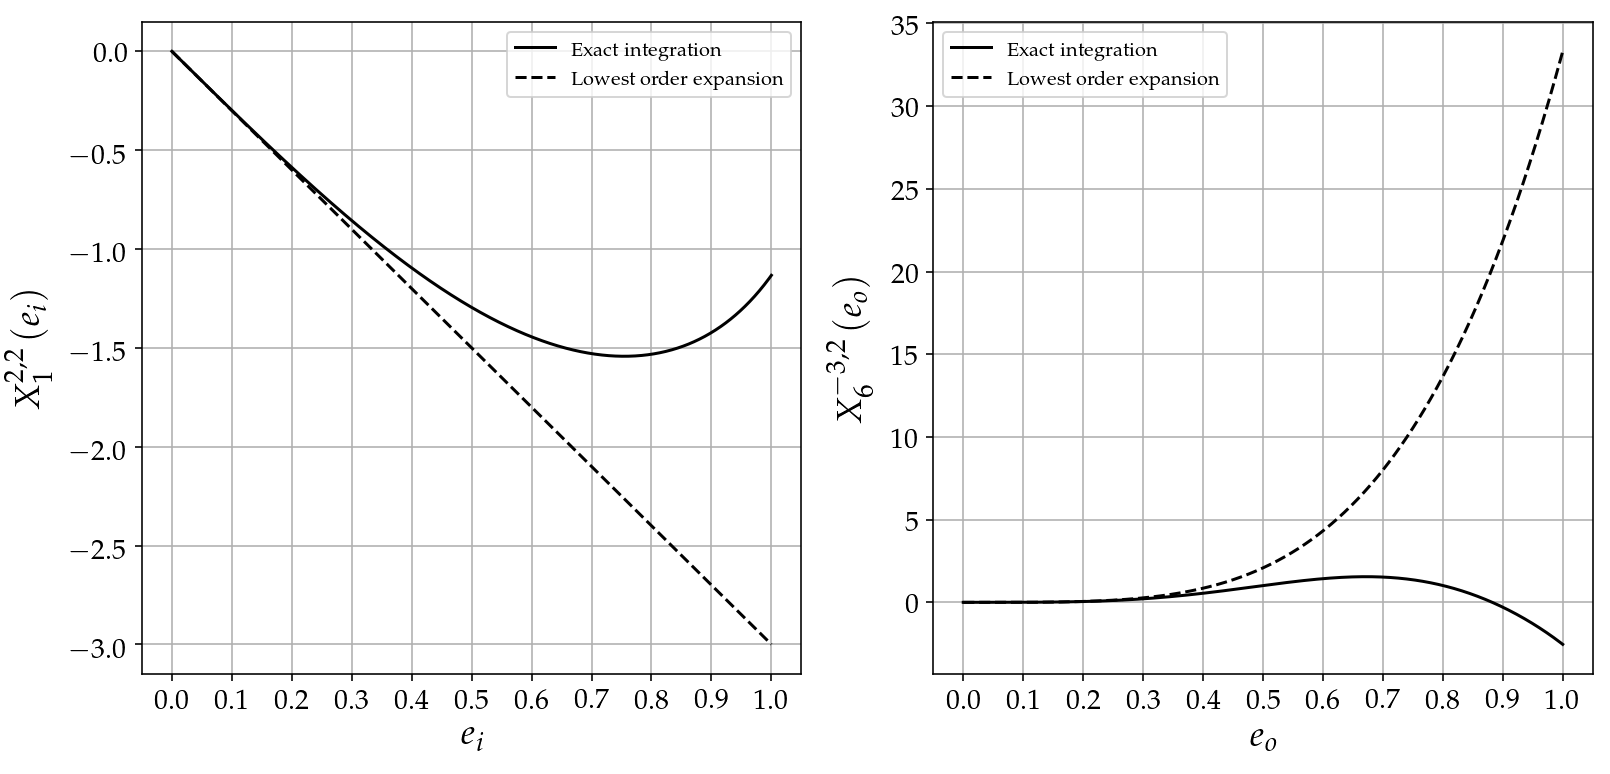

In [25]:
X_inner_approx = lambda a : -3*a
X_inner_true = lambda a : -3*a + (13*a**3)/8 + (5*a**5)/192 + (227*a**7)/3072 + (34349*a**9)/737280\
    + (2957173*a**11)/88473600 + (41963533*a**13)/1651507200\
    + (13410453149*a**15)/665887703040 + (15785824770269*a**17)/958878292377600
    
X_outer_true = lambda a : (533*a**4)/16 - (13827*a**6)/160 + (104127*a**8)/1280\
    - (146017*a**10)/3584 + (1832259*a**12)/143360 - (4045953*a**14)/1433600
X_outer_approx = lambda  a : (533*a**4)/16

e_ = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(1, 2, figsize=(13,6))
ax[0].plot(e_, X_inner_true(e_), 'k', label='Exact integration')
ax[0].plot(e_, X_inner_approx(e_), 'k--', label='Lowest order expansion')
ax[0].set_xlabel(r'$e_i$')
ax[0].set_ylabel(r'$X^{2,2}_1\,(e_i)$')

ax[1].plot(e_, X_outer_true(e_), 'k', label='Exact integration')
ax[1].plot(e_, X_outer_approx(e_), 'k--', label='Lowest order expansion')
ax[1].set_xlabel(r'$e_o$')
ax[1].set_ylabel(r'$X^{-3,2}_6\,(e_o)$')

for a in ax.ravel():
    a.grid(True)
    a.set_xticks(np.linspace(0,1,11))
    a.legend()

# plt.savefig('../figures/analytical_model/hansen_coefficients.pdf', bbox_inches='tight')

As we can see the figure, the lowest order approximation is justifiable only for low eccentricities, $e_i\lesssim 0.3$ and $e_o \lesssim 0.4$. Therefore, the whole subsequent analysis of the 6:1 resonance is valid only in this regime.

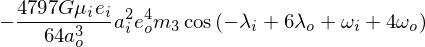

In [26]:
# Define symbols for orbital elements and constants
mu_i, mu_o, a_i, a_o, e_i, e_o, m3, n, G = \
symbols("\mu_i \mu_o a_i a_o e_i e_o m_3 n G", positive=True, real=True)

R_sec, R_res, R = \
    symbols("\mathcal{R}_{sec}, \mathcal{R}_{res}, \mathcal{R}", real=True)
    
lambda_i, lambda_o, w_i, w_o = \
    symbols("\lambda_i, \lambda_o, \omega_i, \omega_o", real=True)

    
# Define Hensen coefficients for n=6    
X_in = -3*e_i
X_ou = 533*e_o**4/16 

# Resonant part of the disturbing function
R_res = Rational(3,4)*G*mu_i*m3/a_o*(a_i/a_o)**2*X_in*X_ou\
*cos(6*lambda_o - lambda_i +4*w_o + w_i)

# Secular part of the disturbing function
# R_sec = G*mu_i*m3/(4*a_o)*(a_i/a_o)**2*(1 + 3*e_i**2/2)/(1 - e_o**2)**(Rational(3, 2))
R_res

The resonant part has a leading term of order $e_ie_o^4$.

# Poincaré variables

Poincaré variables for the inner binary are defined as:

$$\lambda_i = \lambda_i,\quad \Lambda_i = \mu_i \sqrt{G m_{12} a_i} $$
$$\gamma_i = -\omega_i,\quad \Gamma_i = \mu_i \sqrt{G m_{12} a_i} (1-\sqrt{1-e_i^2})$$

Similarly, for the outer binary:

$$\lambda_o = \lambda_o,\quad \Lambda_o = \mu_o \sqrt{G m_{123} a_o}$$
$$\gamma_o = -\omega_o,\quad \Gamma_o = \mu_o \sqrt{G m_{123} a_o} (1-\sqrt{1-e_o^2})$$

We can solve the above system to obtain the expression for the orbital elements expressed in terms of Poincaré momenta. Since the new coordinates and momenta are functions of both the previous momenta and the coordinates,  it is known from the literature that this transformation is canonical.

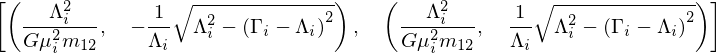

In [27]:
# Define Poincaré variables
Lambda_i, Gamma_i, Lambda_o, Gamma_o, m12, m123 =\
    symbols("\Lambda_i, Gamma_i, \Lambda_o, Gamma_o, m_{12}, m_{123}",
              real=True, positive=True)  
gamma_o, gamma_i = symbols("\gamma_o, \gamma_i", real=True)
    
# Solve for orbital elements in terms of Poincaré variables
x = solve([Eq(mu_i*sqrt(G*m12*a_i) - Lambda_i),
           Eq(mu_i*sqrt(G*m12*a_i)*(1 - sqrt(1 - e_i**2)) - Gamma_i)],
        [a_i, e_i])

x

The second solution is phyiscally meaningful because $e$ is defined to be positive. 
Therefore, the orbital elements in terms of Poincare coordinates are given by:

$$a_i = \frac{\Lambda_i^{2}}{G \mu_i^{2} m_{12}}\quad e_i = \frac{1}{\Lambda_i} \sqrt{\Lambda_i^{2} - \left(\Gamma_{i} - \Lambda_i\right)^{2}}$$

and for the outer part:

$$a_o = \frac{\Lambda_o^{2}}{G \mu_o^{2} m_{123}}\quad e_o = \frac{1}{\Lambda_o} \sqrt{\Lambda_o^{2} - \left(\Gamma_{o} - \Lambda_o\right)^{2}}$$

we can now write the Disturbing function in Poincaré variables:

In [28]:
# Disturbing function in Poincaré coordinates
R = R.subs({a_i: Lambda_i**2/(G*mu_i**2*m12),
            e_i: sqrt(Lambda_i**2 - (Gamma_i - Lambda_i)**2)/Lambda_i,
            a_o: Lambda_o**2/(G*mu_o**2*m123),
            e_o: sqrt(Lambda_o**2 - (Gamma_o - Lambda_o)**2)/Lambda_o,
            w_i: -gamma_i,
            w_o: -gamma_o})
R

# The complete Hamiltonian 

## Keplerian terms

The complete Hamiltonian of the three body system is given by 

$$\mathcal{H}=\mathcal{H}_{kepler}-\mathcal{R}$$

where $\mathcal{H}_{kepler}$ is the Keplerian part.

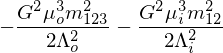

In [29]:
# Define Keplerian hamiltonian in Poincaré coordinates
H = Symbol('\mathcal{H}', real=True)
H_k = Symbol('mathcal{H}_{Kepler}', real=True)
H_k = - G**2*m12**2*mu_i**3/(2*Lambda_i**2) - G**2*m123**2*mu_o**3/(2*Lambda_o**2)
H_k

$$\mathcal{H}_{Kepler}=- \frac{G^{2} \mu_o^{3} m_{123}^{2}}{2 \Lambda_o^{2}} - \frac{G^{2} \mu_i^{3} m_{12}^{2}}{2 \Lambda_i^{2}}$$

Since we're interested in behaviour close to resonance, we can expanded the Keplerian Hamiltonain in a series around a $\Lambda$ wchich corresponds to exact resonance, we denote this value of $\Lambda$ as $\tilde{\Lambda}$.

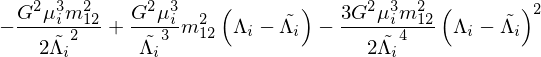

In [30]:
LLambda_o, LLambda_i  =\
symbols(r"\tilde{\Lambda_o}, \tilde{\Lambda_i}", real=True, positive=True)

series(H_k.args[0], Lambda_i, LLambda_i, 3).removeO()

We define new momenta $J_1=\Lambda_i - \tilde{\Lambda_i}$ and 
$J_2=\Lambda_o - \tilde{\Lambda_o}$. The keplerian Hamiltonian is then given by

$$\mathcal{H}_{K}=\frac{G^2 \mu_i^3 m_{12}^2}{2\tilde{\Lambda_i}^3}J_1 -\frac{3 G^2 \mu_i^3 m_{12}^2}{2\tilde{\Lambda_i}^4}J_1^2+ \frac{G^2 \mu_o^3 m_{123}^2}{2\tilde{\Lambda_o}^3}J_2 -\frac{3 G^2 \mu_o^3 m_{123}^2}{2\tilde{\Lambda_o}^4}J_2^2 + const.$$

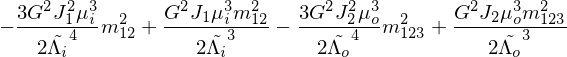

In [31]:
J1, J2 = symbols(r"J_1 J_2", real=True)

ci = G**2*mu_i**3*m12**2
co = G**2*mu_o**3*m123**2

# Expanded Keplerian Hamiltonian
H_kexp = ci*J1/(2*LLambda_i**3) + co*J2/(2*LLambda_o**3) -3*ci*J1**2/(2*LLambda_i**4)\
    -3*co*J2**2/(2*LLambda_o**4)
H_kexp

## Resonant term

We expand the resonant part of the hamiltonian to lowest order in $\Gamma_i$ and 
$\Gamma_o$ and to order 0 in $\Lambda-\widetilde{\Lambda}$. The resulting function is proportional to

$$\mathcal{R}\propto \sqrt{\Gamma_i}{\Gamma_o^2} + \mathcal{O}(\Gamma_i, \Gamma_o^3)$$

In [32]:
H_res = -R

simplify(series(series(H_res, Gamma_i, 0, 1).removeO(), Gamma_o, 0, 3))

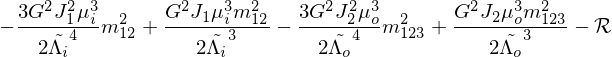

In [33]:
H_res = series(series(H_res, Gamma_i, 0, 1).removeO(), Gamma_o, 0, 3).removeO()
simplify(H_res)
H_res = H_res.subs({
    Lambda_i: LLambda_i,
    Lambda_o: LLambda_o
})

H = H_res + H_kexp
H

## Nondimensionalization

Now that we have the complete Hamiltonian, it is useful to remove physical units.
We proceed by rescaling all masses by a factor $m'$, lengths by factor $a'$.
G is factorized out of the definitions of Poincaré and $J_1$ and
$J_2$ momenta. 

$$\hat{m}_{12}=\frac{m_{12}}{m'}\quad \hat{m}_{123}=\frac{m_{123}}{m'}
\quad \hat{a}_{i}=\frac{a_{i}}{a'}\quad\hat{a}_{o}=\frac{a_{o}}{a'}\quad$$


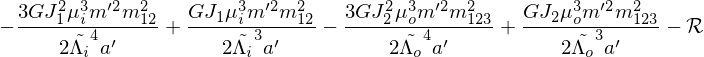

In [34]:
m, a = symbols("m' a'", positive=True)
H = H.subs({
    J1: m*sqrt(G*a*m)*J1,
    J2: m*sqrt(G*a*m)*J2,
    Gamma_i: m*sqrt(G*a*m)*Gamma_i,
    Gamma_o: m*sqrt(G*a*m)*Gamma_o,
    LLambda_i: m*sqrt(G*a*m)*LLambda_i,
    LLambda_o: m*sqrt(G*a*m)*LLambda_o,
    mu_i: m*mu_i,
    mu_o: m*mu_o,
    m12: m*m12,
    m123: m*m123,
    m3: m*m3
})
H

Next, we multiply the Hamiltonian by $a/(M^2G)$ which makes it dimensionless.We put mass in units of the inner binary
mass, length in units of the inner binary semi-major axis at exact resonance, 
and time in units of the inner
binary inverse mean motion.

$$m'=m_{12}\quad a'=\tilde{a_i}$$

therefore, we have $m_{12}$=1, $m_{123}\approx m_{12}=1$ and $\mu_o\approx m_3$.

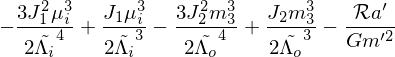

In [35]:
H = H.subs({
    mu_o: m3,
    m12: 1,
    m123: 1,
})
H = H*a/(G*m**2)
simplify(H)

The Hamiltonian is now in a dimensionless form, the Poincaré momenta are defined as follows.

$$ \Lambda_i = \mu_i \sqrt{a_i} \quad \Lambda_o = m_3 \sqrt{ a_o}$$
$$\Gamma_i = \mu_i \sqrt{a_i} (1-\sqrt{1-e_i^2})\quad \Gamma_o = m_3 \sqrt{ a_o} (1-\sqrt{1-e_o^2})$$

where all the quantities are dimensionless (hats omitted).

The final Hamiltonian is then given by:

$$\hat{\mathcal{H}}= -\frac{3 J_1^2\mu_i^3}{2\widetilde{\Lambda}_i^4}+\frac{J_1\mu_i^3}{2\widetilde{\Lambda}_i^3}-\frac{3 J_2^2 m_3^3}{2\widetilde{\Lambda}_o^4}
+\frac{J_2m_3^3}{2\widetilde{\Lambda}_o^3} + 
\frac{4797\sqrt{2}}{16}\frac{m_3^7\widetilde{\Lambda}_i^{7/2}} {\mu_i^3\widetilde{\Lambda}_o^{8}}\sqrt{\Gamma_i}\Gamma_o^2\cos{(\gamma_i+4\gamma_o
+\lambda_i-6\lambda_o)}$$

Where the hat denotes the fact that the Hamiltonian is dimensionless.

# Reduction to a single degree of freedom

In order to reduce the above Hamiltonian to a single degree of freedom, we make use of a canonical transformation which uses the harmonic angle as one of the new conjugate positions. The transformation is of the form:

$$(\lambda_i, \lambda_o,\gamma_i, \gamma_o, J_1, J_2, \Gamma_i, \Gamma_o)
\rightarrow(\theta_1, \theta_2, \theta_3, \theta_4, \Theta_1, \Theta_2, \Theta_3, \Theta_4)$$

it is generated by the generating function of the 2nd type defined below.

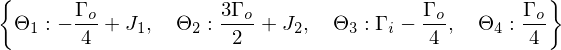

In [36]:
# Define new coordinates and momenta
t1, t2, t3, t4, T1, T2, T3, T4 =\
symbols(r"\theta_1, \theta_2, \theta_3, \theta_4, \Theta_1, \Theta_2, \Theta_3, \Theta_4",
        real=True)

# Specify F2
F2 = (gamma_i + 4*gamma_o + lambda_i - 6*lambda_o)*T4 + lambda_i*T1 + lambda_o*T2\
    + gamma_i*T3

H = H.subs({
    J1: diff(F2, lambda_i),
    J2: diff(F2, lambda_o),
    Gamma_i: diff(F2, gamma_i),
    Gamma_o: diff(F2, gamma_o),
    gamma_i: t4 -(4*gamma_o + lambda_i - 6*lambda_o)
})

# Solve for new momenta in terms of old momenta
sol = solve([
    Eq(diff(F2, lambda_i) - J1),
    Eq(diff(F2, lambda_o) - J2),
    Eq(diff(F2, gamma_i) - Gamma_i),
    Eq(diff(F2, gamma_o) - Gamma_o)], [T1, T2, T3 ,T4])
sol

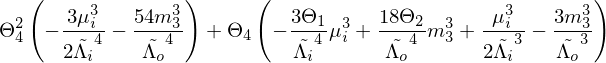

In [37]:
H = collect(expand(H), T4).args[0] + collect(expand(H), T4).args[1]
H

The square root next to the cosine term is problematic, we thus use the approximation $\Theta_1\ll\Theta_2$. This approximation relies on the fact that $\Gamma_o/\Gamma_i$ is small which is true only if $m_3$ is small compared to $m_1$ and $m_2$ and if $e_o<e_i$. The approximation breaks down when the outer eccentricty surpasses the inner.

Substituting $\Phi\equiv\Theta_4$ and $\phi\equiv\theta_4$, expanding 
$\sqrt{\Theta_3 + \Theta_4}\approx \sqrt{\Theta_3}$, we obtain the following Hamiltonian

$$\hat{\mathcal{H}}= \left(-\frac{3\mu_i^3}{2\widetilde{\Lambda}_i^4}-\frac{54 m_3^3}{\widetilde{\Lambda}_o^4}\right)\Phi^2
+ \left(\frac{\mu_i^3}{2\widetilde{\Lambda}_i^3} - 
\frac{3m_3^3}{\widetilde{\Lambda}_o^3} + 
\frac{18\Theta_2m_3^3}{\widetilde{\Lambda}_o^4} - 
\frac{3\Theta_1\mu_i^3}{\widetilde{\Lambda}_i^4}\right)\Phi
+\frac{4797\sqrt{2}}{16}\frac{m_3^7\widetilde{\Lambda}_i^{7/2}} {\mu_i^3\widetilde{\Lambda}_o^{8}}\sqrt{\Theta_3}\Phi^2\cos{\phi}$$

or simply

$$\hat{\mathcal{H}}=\alpha\Phi^2  +\beta\Phi +
\frac{4797\sqrt{2}}{64}\frac{m_3^7\widetilde{\Lambda}_i^{7/2}} {\mu_i^3\widetilde{\Lambda}_o^{8}}\sqrt{\Theta_3}(2\Phi)^2\cos{\phi}$$

where

$$\alpha=-\frac{3\mu_i^3}{2\widetilde{\Lambda}_i^4} -
\frac{54m_3^3}{\widetilde{\Lambda}_o^4}$$

and

$$\beta \approx \frac{\mu_i^3}{2\widetilde{\Lambda}_i^3} -
\frac{3m_3^3}{\widetilde{\Lambda}_o^3} $$


By using the canonical transformation $\Phi\rightarrow \Phi/4$
and $\phi\rightarrow 4\phi$, and dividing by $\alpha/16$  we obtain


$$\hat{\mathcal{H}}' = \Phi^2  -\delta\Phi + \epsilon(2\Phi)^2\cos{4\phi}$$

where 

$$\delta=-\frac{4\beta}{\alpha},\quad
\epsilon=\frac{4797\sqrt{2}}{64}\frac{m_3^7\widetilde{\Lambda}_i^{7/2}} {\alpha\mu_i^3\widetilde{\Lambda}_o^{8}}\sqrt{\Theta_3}$$

# Andoyer Hamiltonian 

The Hamiltonian we have derived above is called an Andoyer Hamiltonian of degree 4. In general, an Andoyer Hamiltonian of degree $k$ is defined as

$$\mathcal{H}_k=a\Phi+b\Phi^2+\epsilon\tau(2\Phi)^{k/2}\cos k\phi$$

In our case, $b=1$, and the Hamiltonian depends on two parameters, $a=-\delta$, $\epsilon\tau=\epsilon$. $\delta$ can be either positive or negative, $\epsilon$ is always positive and small ($<<1$) and $\Phi$ is always positive.

Because the coordinates $(\phi,\Phi)$ are singular at $\Phi=0$, it is customary to introduce the following Cartesian coordinates

$$x=\sqrt{2\Phi}\cos{k\phi}\quad y=\sqrt{2\Phi}\sin{k\phi}$$

This would be the standard polar to Cartesian coordinate transformation  were it not for  the square roots which are necessary for the transformation to be canonical. After the transformation and substituting $k=4$, we obtain the following Hamiltonian

$$\mathcal{H}_4=-\delta\frac{1}{2}(x^2+y^2)+\frac{1}{4}(x^2+y^2)^2+\epsilon(x^2+y^2)^{3/2}\lvert x\rvert$$

To find the fixed points, we solve the follwing system

$$\frac{\partial\mathcal{H}_4}{\partial x}=\frac{\partial\mathcal{H}_4}{\partial y}=0$$

the results is

$$\frac{\partial\mathcal{H}_4}{\partial x}=2Dx+\epsilon(x^2+y^2)^{3/2}=0$$
$$\frac{\partial\mathcal{H}_4}{\partial y}=2Dy=0$$

where $D$ is the partial derivative of $\mathcal{H}_4$ with respect to $(x^2+y^2)$. 
It immediately follows that $y=0$, if $D$ were zero from the first equation we would have 
that $\epsilon=0$ which isn't the case. Thus, all fixed points necessarily lie on the $x$
axis. Inserting $y=0$ in the first equation, we get

$$-\delta x+x^3 + 4\epsilon x^2\lvert x\rvert =0$$

### Stability of the fixed points
In order to characterise the fixed points of a two dimensional system of first order
differential equations, we look at the linearized system near the fixed points.
Suppose that $\dot{x}_i=f_i(x)$ and $x=a$ is a fixed point, so $f(a)=0$. We can then taylor expand $f$ as follows

$$\dot{x}_i=f_i(a)+\frac{\partial f_i}{\partial x_j}(a)\xi_j + \mathcal{O}(\xi^2)$$

where $\xi=x-a$. It follows that

$$\dot{\xi}=A\xi$$

is the linearized system evaluated at the fixed point $a$. A is called the Jacobian matrix. 

For Hamiltonian systems with a single degree of freedom we can only have three types
of fixed points because
of conservation of phase space volume (Liouville's theorem). They are
\emph{hyperbolic} (saddle points), \emph{elliptic} (centre point) and 
\emph{parabolic} (shear point) (see 

The determinant of the Hessian matrix for our Hamiltonian is given by

$$\Delta_4=det\left( \frac{\partial\mathcal{H}_4}{\partial x_i\partial x_j}\right)$$

The result, when the equation for the fixed points is taken into account, is 

$$\Delta_4 = -2\delta\epsilon x\lvert x\rvert$$

If $\Delta_4$ is positive the singular point is a center, if it is negative it is a saddle, and if it is zero the singularity is a double point. The origin $x=0, y=0$ is 
always a singular point for $k\neq 1$. 

From the equation for the location of fixed points, it follows that there is one saddle point to the right of origin (which is a center), and one center point to the left when $\delta > 0$. When $\delta$ is negative there is only one fixed point at the origin.

### Morphogenesis


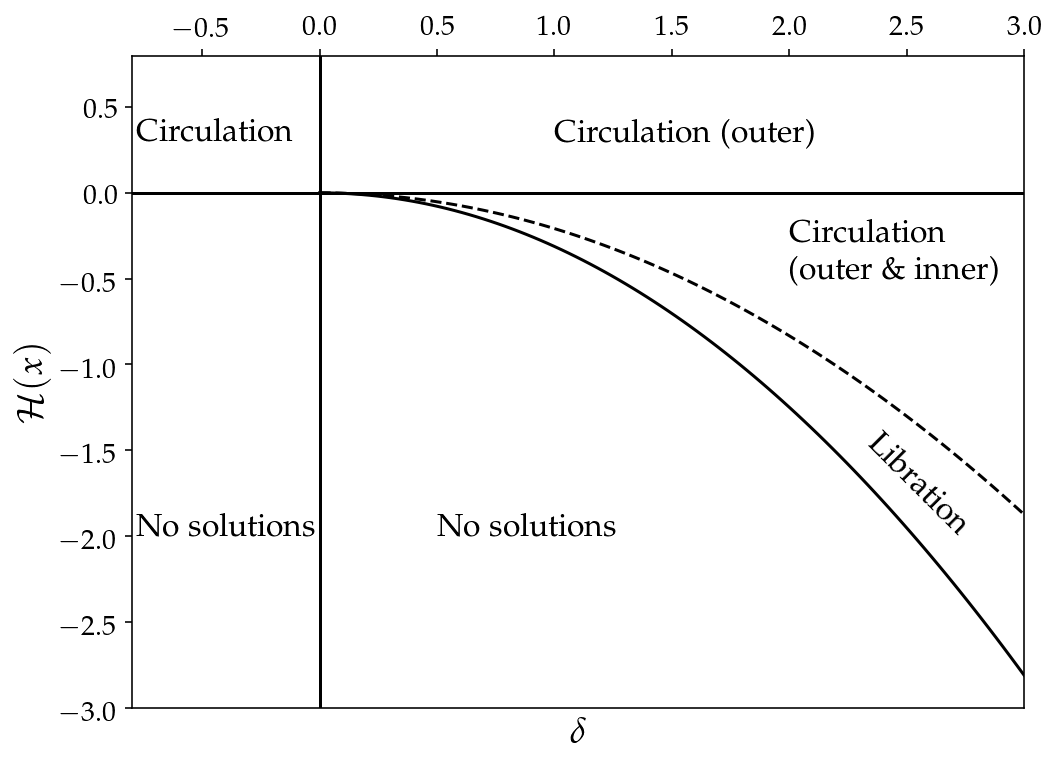

In [38]:
H_4 = lambda x, eps, delta: x**4/4 - delta*x**2/2 + eps*np.abs(x)*x**3

eps_ = 0.05
delta_ = np.linspace(0, 3, 100)

x_center = -np.sqrt(delta_/(1 - 4*eps_))
x_saddle = np.sqrt(delta_/(1 + 4*eps_))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(delta_, H_4(x_center, eps_, delta_), 'k')
ax.plot(delta_, H_4(x_saddle, eps_, delta_), 'k--')
# ax.grid(True)
ax.set_xlim(-0.8, 3)
ax.set_ylim(-3.,0.8)
ax.xaxis.tick_top()
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.text(2.3, -1.5, 'Libration', fontsize=16, rotation=-45)
ax.text(2., -0.5, 'Circulation\n(outer \& inner)', fontsize=16)
ax.text(0.5, -2, 'No solutions', fontsize=16)
ax.text(-0.78, -2, 'No solutions', fontsize=16)
ax.text(-0.78, 0.3, 'Circulation', fontsize=16)
ax.text(1, 0.3, 'Circulation (outer)', fontsize=16)
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$\mathcal{H}(x)$')
plt.savefig('../figures/analytical_model/morpogenesis.pdf', bbox_inches='tight')

### Phase space plots

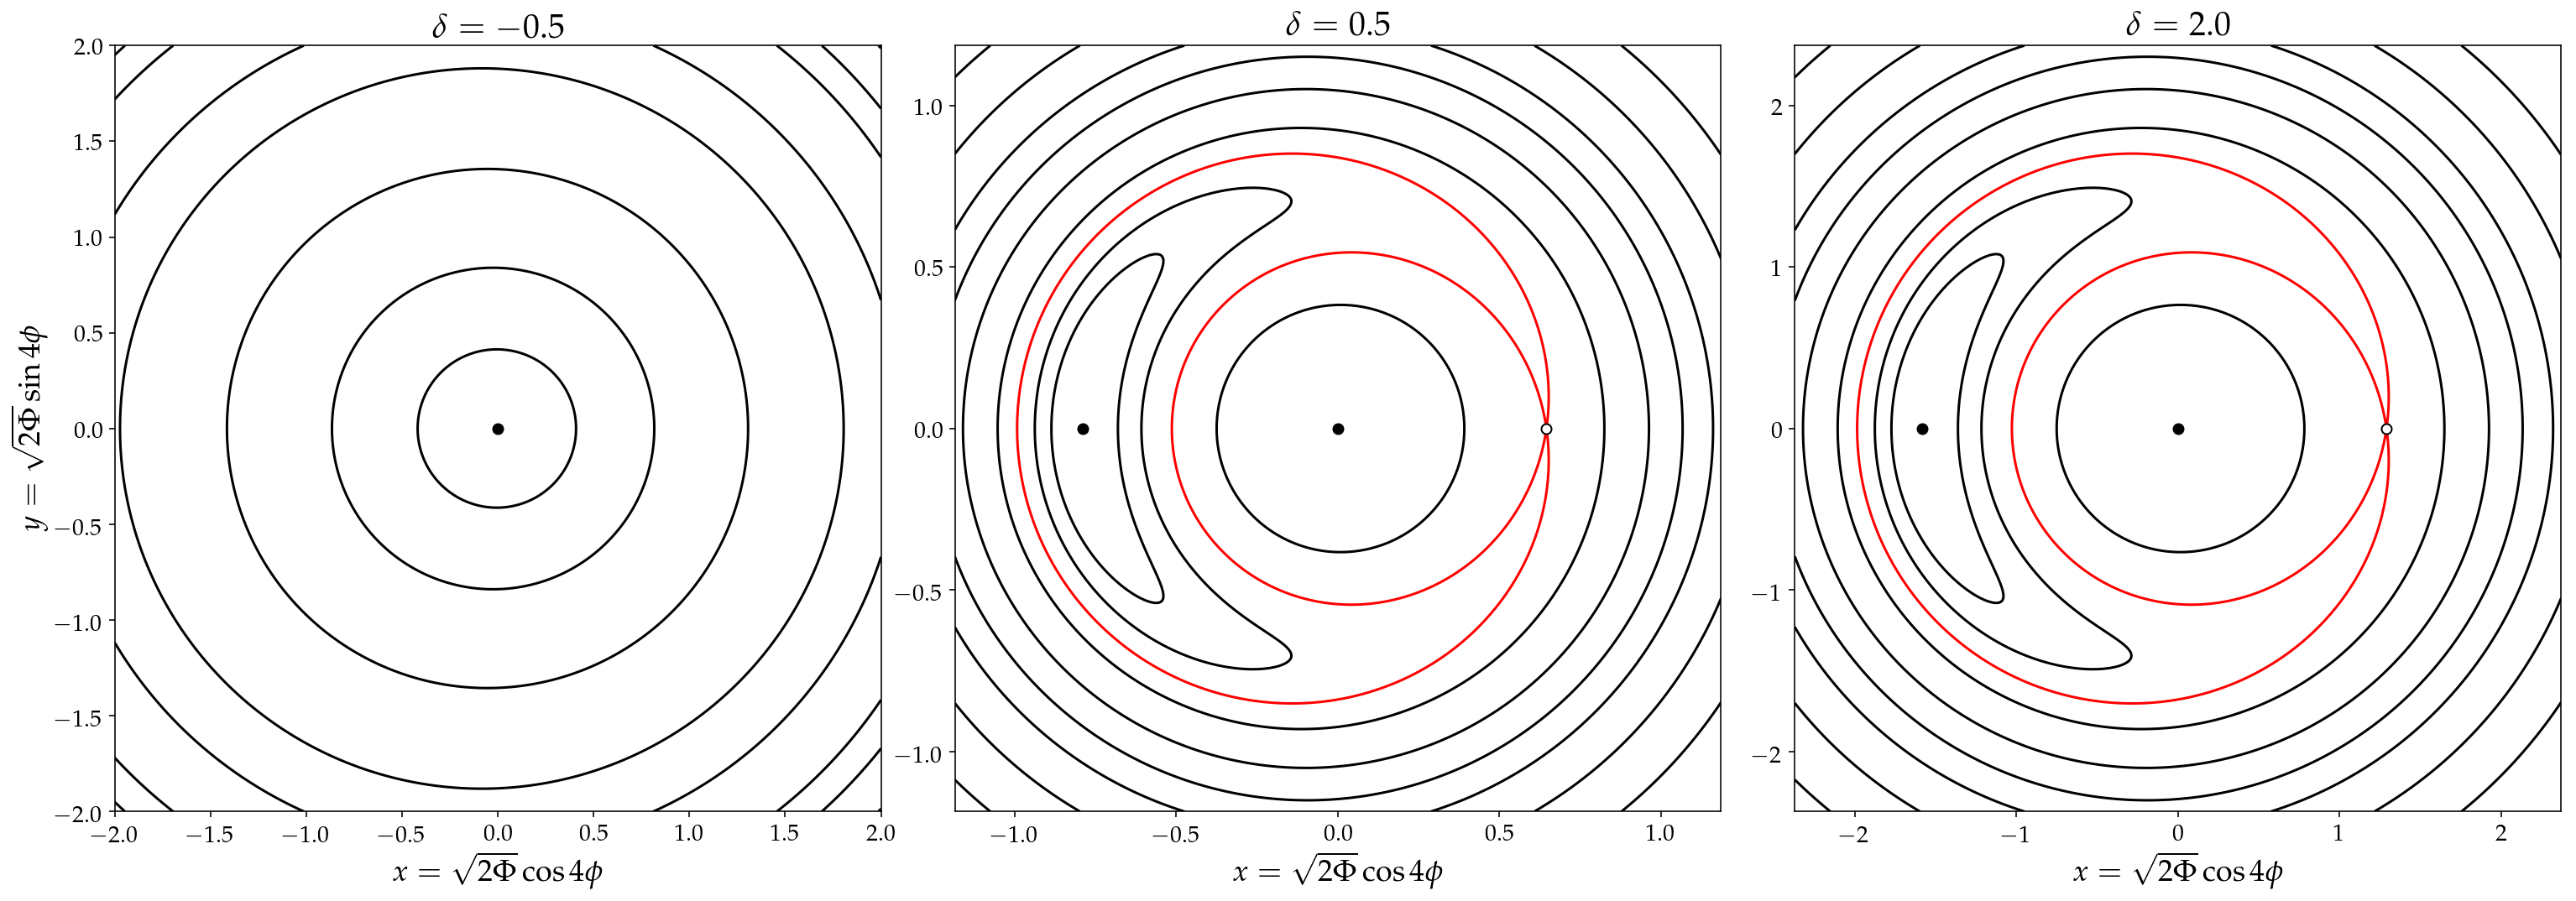

In [39]:
def plot_hamiltonian(ax, delta, eps):      
    """
    Calculate the Hamiltonian as a function of x and y coordinates, defined
    as x=sqrt(2*Phi)*cos(phi), y=sqrt(2*Phi)*sin(phi)
    """      
    # Define the Hamiltonian in Cartesian coordinates
    H = lambda X, Y: -delta*(X**2 + Y**2)/2 + (X**2 + Y**2)**2/4 + eps*X*(X**2 + Y**2)**(3/2)

    if(delta > 0):
        # Define (x,y) grid
        l = np.sqrt(delta/(1 - 4*eps))*1.5
        x = np.linspace(-l, l, 2000)
        y = np.linspace(-l, l, 2000)

        X, Y = np.meshgrid(x, y)
    
        # Value of H at the separatrix
        H_saddle = H(np.sqrt(delta/(1 + 4*eps)), 0)
        H_center = H(-np.sqrt(delta/(1 - 4*eps)), 0)

        levels = np.array([1.4, 1.25, 0.6,\
                            -.5, -2., -4., -8., -15.])*H_saddle

        separatrix = ax.contour(X, Y, H(X,Y), levels=[H_saddle], colors='red',zorder=1)
        for line in separatrix.collections:
            line.set_linestyle('solid')

        contour = ax.contour(X, Y, H(X,Y), levels=levels, colors='black')

        for line in contour.collections:
            line.set_linestyle('solid')

        # Plot the fixed points
        x_centers = np.array([0, -np.sqrt(delta/(1 - 4*eps))])
        y_centers = np.zeros(2)
        x_saddle = np.sqrt(delta/(1 + 4*eps))
        y_saddle = 0

        ax.scatter(x_centers, y_centers, color='black')
        ax.scatter(x_saddle, y_saddle, facecolor='white', edgecolor='black', zorder=2)
        ax.set_title(r"$\delta = {:.1f}$".format(delta))
        
    else:
        # Define (x,y) grid
        l = 2.
        x = np.linspace(-l, l, 2000)
        y = np.linspace(-l, l, 2000)
        X, Y = np.meshgrid(x, y)
        
        levels = np.array([0.05, 0.3, 1.3, 4., 7., 12., 15. ,20.])
        
        contour = ax.contour(X, Y, H(X,Y), levels=levels, colors='black')
        
        # Plot the fixed points
        ax.scatter(0, 0, color='black')
        ax.set_title(r"$\delta = {:.1f}$".format(delta))


fig, ax = plt.subplots(1, 3, figsize=(21, 7))
plt.tight_layout()

plot_hamiltonian(ax[0], -0.5, 0.05)
plot_hamiltonian(ax[1], 0.5, 0.05)
plot_hamiltonian(ax[2], 2., 0.05)

for a in ax.ravel():
    a.set_xlabel(r'$x=\sqrt{2\Phi}\cos{4\phi}$')
#     a.set_aspect('equal')
ax[0].set_ylabel(r'$y=\sqrt{2\Phi}\sin{4\phi}$')

# plt.savefig('../figures/analytical_model/phase_space_plot.png', bbox_inches='tight')

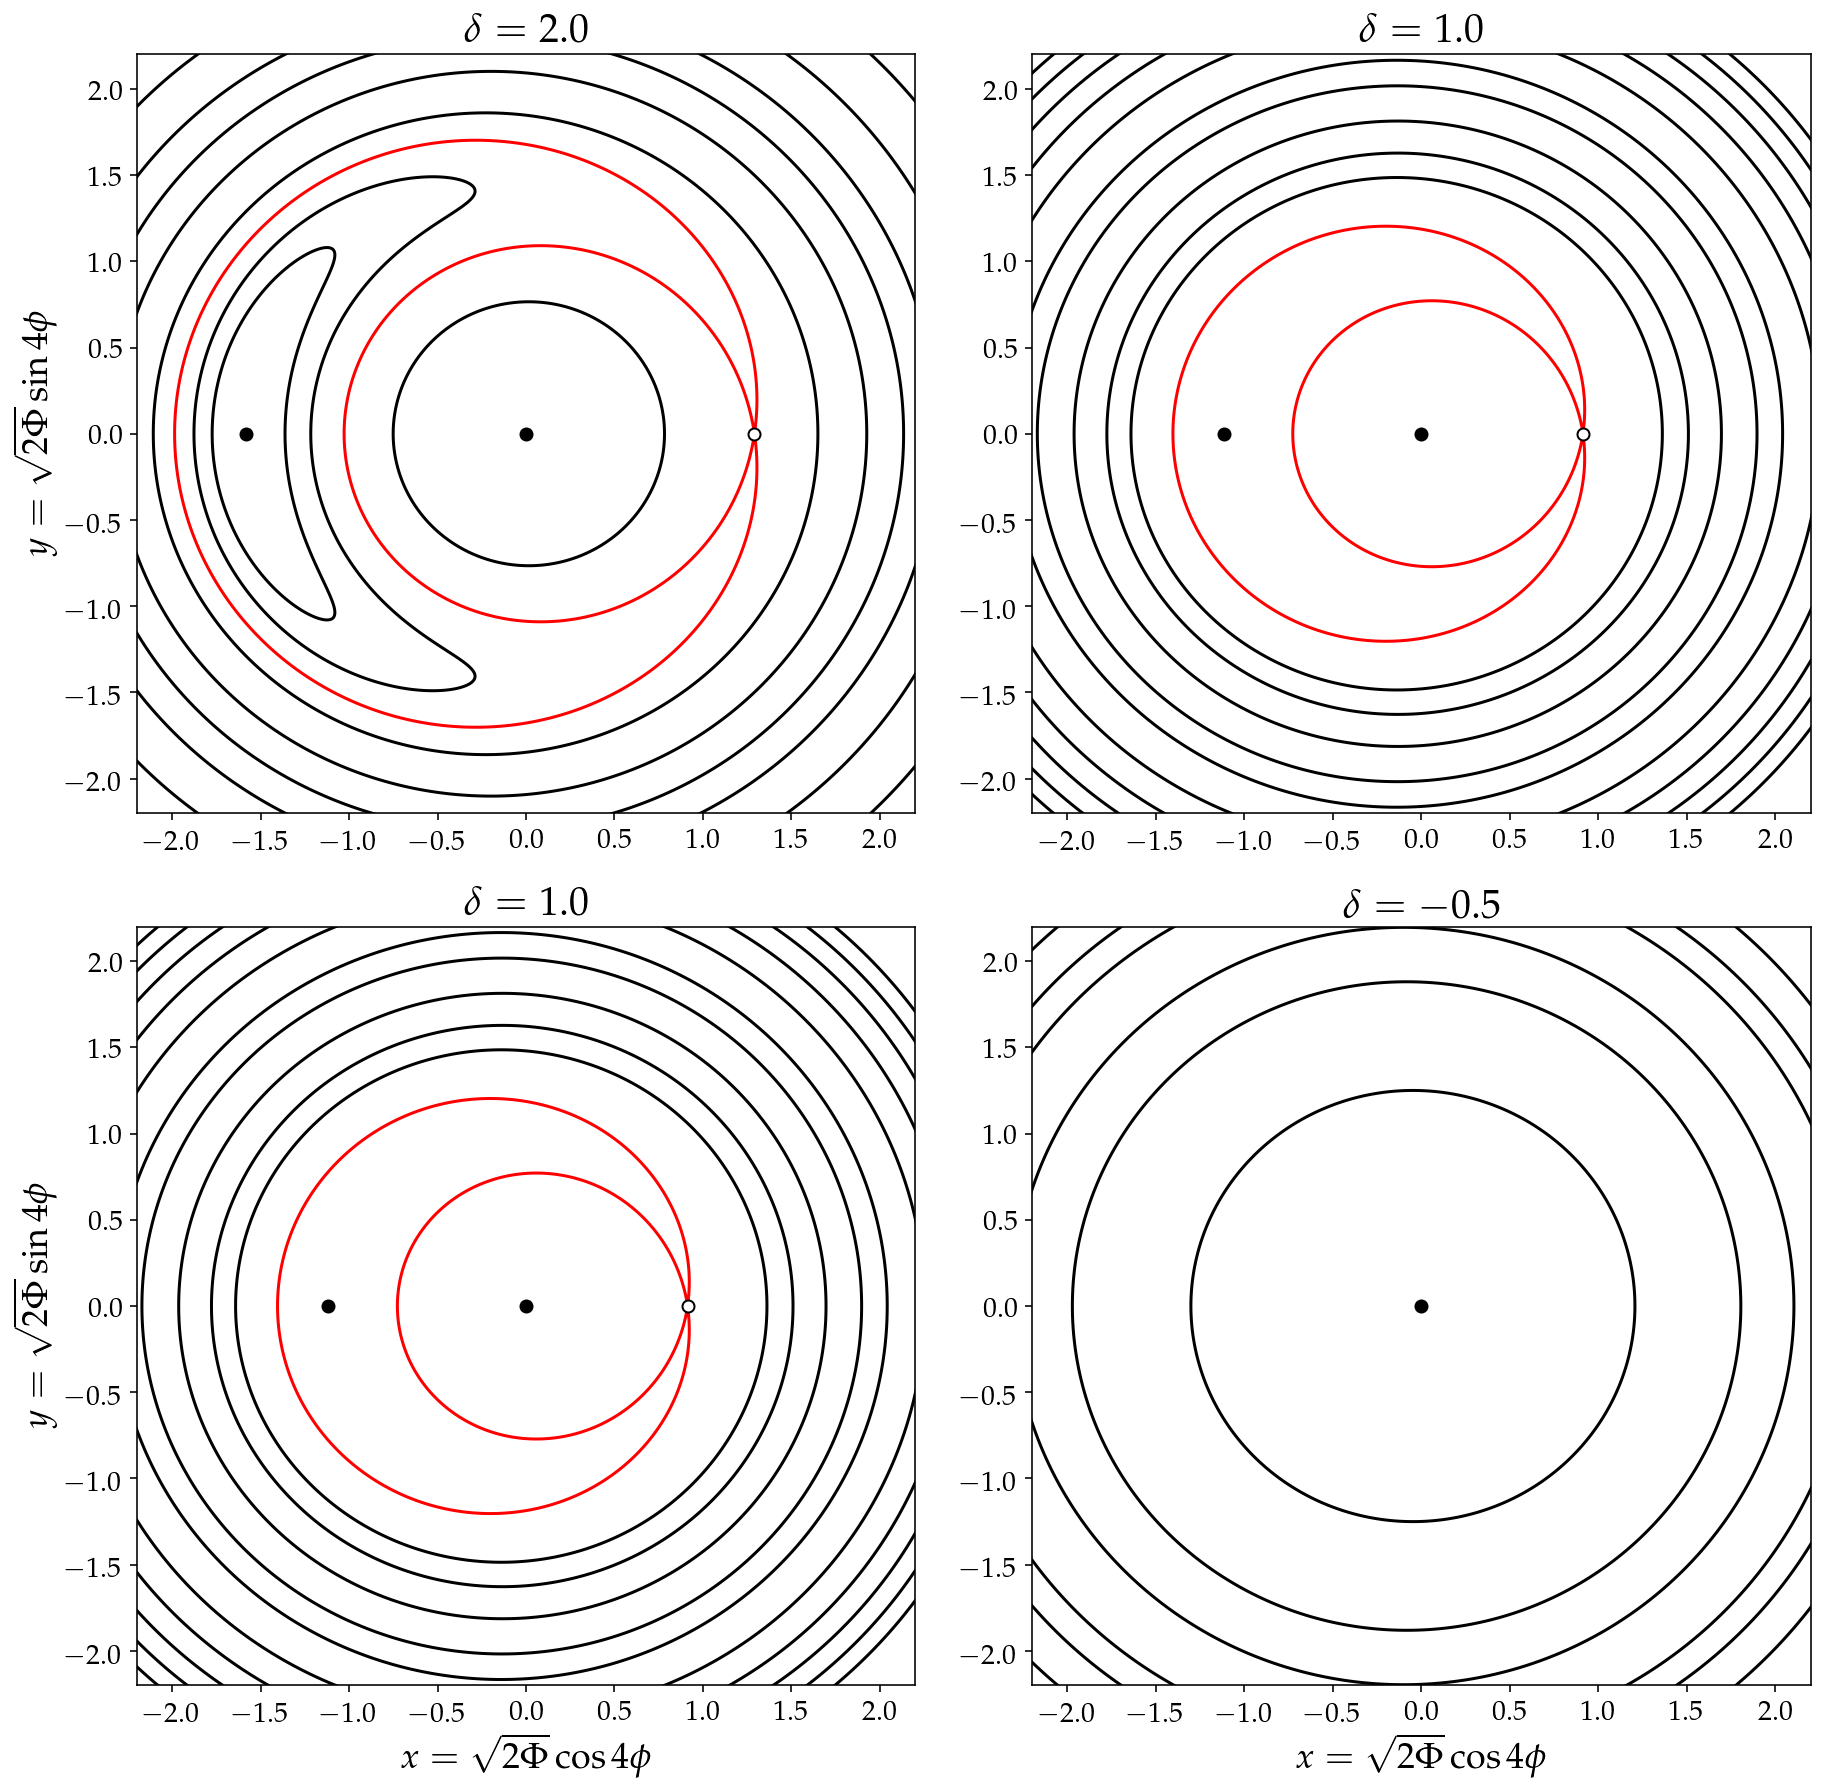

In [63]:
# Make a different plot which will later be edited to show the jump 
# in the adiabatic invariant
def plot_hamiltonian_adiabatic(ax, delta, eps):      
    """
    Calculate the Hamiltonian as a function of x and y coordinates, defined
    as x=sqrt(2*Phi)*cos(phi), y=sqrt(2*Phi)*sin(phi)
    """      
    # Define the Hamiltonian in Cartesian coordinates
    H = lambda X, Y: -delta*(X**2 + Y**2)/2 + (X**2 + Y**2)**2/4 + eps*X*(X**2 + Y**2)**(3/2)

    if(delta > 0):
        # Define (x,y) grid
        l = np.sqrt(delta/(1 - 4*eps))*5
        x = np.linspace(-l, l, 2000)
        y = np.linspace(-l, l, 2000)

        X, Y = np.meshgrid(x, y)
    
        # Value of H at the separatrix
        H_saddle = H(np.sqrt(delta/(1 + 4*eps)), 0)
        H_center = H(-np.sqrt(delta/(1 - 4*eps)), 0)

        levels = np.array([ -.5, -2., -5., -10., -15., -25., -35, -45, -55, -65])*H_saddle

        separatrix = ax.contour(X, Y, H(X,Y), levels=[H_saddle], colors='red',zorder=1)
        for line in separatrix.collections:
            line.set_linestyle('solid')

        contour = ax.contour(X, Y, H(X,Y), levels=levels, colors='black')

        for line in contour.collections:
            line.set_linestyle('solid')

        # Plot the fixed points
        x_centers = np.array([0, -np.sqrt(delta/(1 - 4*eps))])
        y_centers = np.zeros(2)
        x_saddle = np.sqrt(delta/(1 + 4*eps))
        y_saddle = 0

        ax.scatter(x_centers, y_centers, color='black')
        ax.scatter(x_saddle, y_saddle, facecolor='white', edgecolor='black', zorder=2)
        ax.set_title(r"$\delta = {:.1f}$".format(delta))
        
    else:
        # Define (x,y) grid
        l = 4.
        x = np.linspace(-l, l, 2000)
        y = np.linspace(-l, l, 2000)
        X, Y = np.meshgrid(x, y)
        
        levels = np.array([1., 4., 7., 12., 15. ,20.])
        
        contour = ax.contour(X, Y, H(X,Y), levels=levels, colors='black')
        
        # Plot the fixed points
        ax.scatter(0, 0, color='black')
        ax.set_title(r"$\delta = {:.1f}$".format(delta))


fig, ax = plt.subplots(2, 2,figsize=(15, 15))
plt.subplots_adjust(hspace=0.15, wspace=0.15)

plot_hamiltonian(ax[0, 0], 2., 0.05)
plot_hamiltonian_adiabatic(ax[0, 1], 1., 0.05)
plot_hamiltonian_adiabatic(ax[1, 0], 1., 0.05)
plot_hamiltonian_adiabatic(ax[1, 1], -0.5, 0.05)


ax[1,0].set_xlabel(r'$x=\sqrt{2\Phi}\cos{4\phi}$')
ax[1,1].set_xlabel(r'$x=\sqrt{2\Phi}\cos{4\phi}$')
ax[0,0].set_ylabel(r'$y=\sqrt{2\Phi}\sin{4\phi}$')
ax[1,0].set_ylabel(r'$y=\sqrt{2\Phi}\sin{4\phi}$')

for a in ax.ravel():
    a.set_xlim(-2.2, 2.2)
    a.set_ylim(-2.2, 2.2)

plt.savefig('../figures/analytical_model/phase_space_plot.svg', bbox_inches='tight')

## The Adiabatic invariant and the eccentricity kick

In order to estimate the eccentricity kick, we first need to calculate the area enclosed
by the inner and outer branches of the separatrix as a function of delta. We first solve for the roots of the separatrix equation as follows

$$\mathcal{H}\rvert_{y=0}=\frac{1}{2} x^2+\frac{1}{4}\delta x^4+\epsilon x^3\lvert x\rvert$$

$$\mathcal{H}_{sep}=\mathcal{H}\left( x_{saddle}\right) = 
\mathcal{H}\left( -\sqrt{\frac{-\delta^2}{1-4\epsilon}}\right)$$

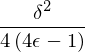

In [41]:
x, y, delta = symbols(r"x y \delta", real=True)
eps = symbols(r'\epsilon', real=True, positive=True)

H_x =-delta*x**2/2 + x**4/4 - eps*x**4

H_sep = H_x.subs({
    x: sqrt(delta/(1 - 4*eps))})

H_sep = simplify(H_sep)
H_sep

This is the value of the Hamiltonian at the separatrix, the equation for the separatrix is then given by

$$\mathcal{H}_{sep}=\mathcal{H}(x)$$

that is

$$\frac{-\delta^2}{4(1-4\epsilon)}=\frac{1}{2} x^2+\frac{1}{4}\delta x^4+\epsilon x^3\lvert x\rvert$$

the result is


In [42]:
x_center = -sqrt(delta/(1 - 4*eps))
x_saddle = sqrt(delta/(1 + 4*eps))

# Define the Hamiltonian in Cartesian coordinates
H = lambda X, Y: -delta*(X**2 + Y**2)/2 + (X**2 + Y**2)**2/4 +\
    eps*abs(X)*(X**2 + Y**2)**Rational(3/2)

The action of a Hamiltonian system is defined by:

$$J=\oint \Phi\, d\phi$$

which is simply the area enclosed by a level curve. To calculate the actions associated 
with the inner and outer branches of the separatrix, we make use of the Hamilton's equations to switch the integration variable to $\phi$.

$$d\phi = \frac{\dot{\phi}}{\dot{\Phi}}d\Phi$$

therefore

$$J=\oint \Phi\frac{\dot{\phi}}{\dot{\Phi}}d\Phi$$

equivalently, in cartesian coordinates

$$J=\oint x\, dy$$

or

$$J=\oint x\frac{\dot{y}}{\dot{x}}dx$$

In [43]:
Phi, phi = symbols(r"\Phi \phi", real=True)
H_4 = lambda Phi, phi: -delta*Phi + Phi**2 + 4*eps*Phi**2*cos(4*phi)
diff(H_4(Phi, phi), Phi)


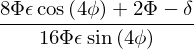

In [44]:
integrand = -Phi*diff(H_4(Phi,phi), Phi)/diff(H_4(Phi,phi), phi)
integrand

To solve the integral, we need to solve for $\cos (4\phi)$ and $\sin (4\phi)$ in terms of $\Phi$ and $\mathcal{H}_{sep}$. To do this, we make use of the equation for separatrix, in $(\Phi,\phi)$ coordinates.

In [45]:
H_sepsym = symbols(r'\mathcal{H}_{sep}', real=True)
sep_eq = Eq(H_4(Phi, phi) - H_sepsym)
sep_eq

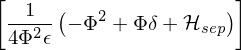

In [46]:
sol = solve(sep_eq, cos(4*phi))
sol

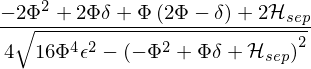

In [47]:
cos4phi = sol[0]
sin4phi = sqrt(1 - sol[0]**2)

integrand = integrand.subs({
    cos(4*phi): cos4phi,
    sin(4*phi): sin4phi
})
integrand = simplify(integrand)
integrand

In [48]:
saddle_point = -(delta**2/2)/(1 - 4*eps)
lower_branch = (delta/2)/(1 - 4*eps)*(1 - sqrt(8*eps/(1 + 4*eps)))
upper_branch = (delta/2)/(1 - 4*eps)*(1 + sqrt(8*eps/(1 + 4*eps)))

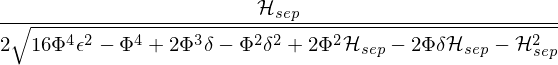

In [49]:
test = simplify(expand(integrand).args[0])
test

In [50]:
# A_inner = integrate(test, Phi)
# A_inner

In [51]:
# A_outer = integrate(integrand, (Phi, saddle_point, upper_branch))
# A_outer

# Calculate eccentricity kick

We start with a circle in the phase plane, the initial action is given by

$$A_{initial}=2\pi\Phi_{initial}=\frac{\pi}{2}\Gamma_o=
\frac{\pi}{2}\Lambda_o\left(1-\sqrt{1 - e_o^2}\right)$$

The area enclosed by the inner separatrix branch is given by

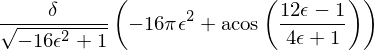

In [52]:
A_inner_branch = lambda delta, eps: (delta/sqrt(1 - 16*eps**2))*\
    (acos((12*eps - 1)/(1 + 4*eps)) - pi*16*eps**2)
    
A_outer_branch = lambda delta, eps: delta/sqrt(1 - 16*eps**2)*\
    (pi*(2 - 16*eps**2) - acos((12*eps - 1)/(1 + 4*eps)))

A_inner_branch(delta, eps)

The area enclosed by the inner branch and the inital action define a value of $\delta$ 
called $\delta_t$ at which the initial action equals the inner separatrix action.

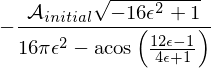

In [53]:
A_initial, A_final = symbols(r'\mathcal{A}_{initial} \mathcal{A}_{final}', real=True)
delta_transition = solve(A_inner_branch(delta, eps) - A_initial, delta)
delta_transition[0]

The area of enclosed by the outer branch of the separatrix at $\delta=\delta_t$ is then
equal to

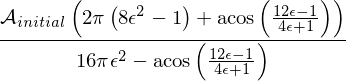

In [54]:
final_action = simplify(A_outer_branch(delta_transition[0], eps))
final_action

We can solve for the ratio between those actions

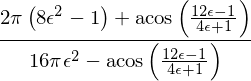

In [55]:
action_ratio = simplify(final_action/A_initial)
action_ratio

Therefore, we have

$$\frac{\mathcal{A}_{final}}{\mathcal{A}_{inital}}=\frac{2 \pi \left(8 \epsilon^{2} - 1\right) + \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right )}}{16 \pi \epsilon^{2} - \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right )}}=\frac{\Gamma_{o,final}}{\Gamma_{o,initial}}=\left(\frac{P_{o,final}}{P_{o,init}}\right)^{1/3}
\frac{1 - \sqrt{1 - e_{o,final}^2}}{1 - \sqrt{1 - e_{o, initial}^2}}$$
and the final eccentricity is

$$e_{o,final}^2=1 - \left(1 - \left(1 - \sqrt{1 - e_{o, initial}}\right) \frac{2 \pi \left(8 \epsilon^{2} - 1\right) + \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right)}}{16 \pi \epsilon^{2} - \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right)}}\right)^2$$

the kick in eccentricity depends only on the initial eccenetricity and $\epsilon$.

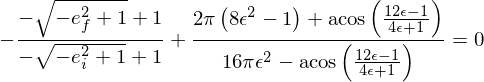

In [56]:
e_o_init, e_o_final = symbols(r'e_i, e_f', real=True, positive=True)

equation = Eq(action_ratio - (1 - sqrt(1 - e_o_final**2))/(1 - sqrt(1 - e_o_init**2)))
equation

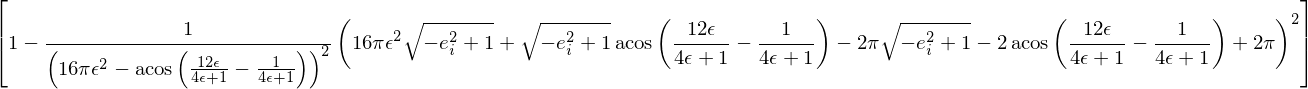

In [57]:
simplify(solve(equation, e_o_final**2))

In [58]:
ratio = lambda eps: (2*np.pi*(8*eps**2 - 1) + np.arccos((12*eps - 1)/(4*eps + 1)))\
                     /(16*np.pi*eps**2 - np.arccos((12*eps - 1)/(4*eps + 1)))
                     
final_ecc = lambda eps, e_init: np.sqrt(1 - (1 - (1 - np.sqrt(1 - e_init))*ratio(eps))**2)
            
ecc_init = 0.01
final_ecc(0.03, ecc_init)